In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio.PDB import *
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob

import esm

torch.set_grad_enabled(False)

In [2]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

parser = PDBParser(PERMISSIVE = True, QUIET = True) 
pdbl = PDBList() 

def get_pdb_residues(PDB_ID):
    pdb = PDB_ID.upper()[:4]
    chain_id = PDB_ID.upper()[-1]
    
    ## Get the data from the pdb file
    pdbl.retrieve_pdb_file(PDB_ID.upper()[:4], pdir = '.', file_format = 'pdb')
    data = parser.get_structure(pdb,"pdb" + pdb.lower() + ".ent")
    os.remove("pdb" + pdb.lower() + ".ent")

    all_residues = {}
    
    missing = [res for res in data.header["missing_residues"] if res["chain"] == chain_id]
    for res in missing:
        key = res["ssseq"]
        all_residues[key] = False
    
    model = list(data.get_models())[0]
    chains = list(model.get_chains()) 
    residues = list([chain for chain in chains if chain.id == chain_id][0].get_residues())
    residues = [res for res in residues if str(res)[17] == ' ']
    for res in residues:
        if not str(res)[28].isnumeric():
            key = int(str(res)[26:28])
        elif not str(res)[29].isnumeric():
            key = int(str(res)[26:29])
        else:
            key = int(str(res)[26:30])
        all_residues[key] = True
    
    pdb_indices = []
    index = 0
    for i in range(10000):
        if i in all_residues:
            if all_residues[i]:
                pdb_indices.append(index)
            index += 1
    return pdb_indices

"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

def display_output_heatmap(data, title):
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(24, 8))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=4)
    plt.title(title)
    plt.show()


In [3]:
print("Previous device?", torch.cuda.current_device())

torch.cuda.set_device(1)

print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())

Previous device? 0
Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 2
Current device? 1


In [4]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [5]:
REF_0, REF_1 = "2qke_e", "5jyt_a"
#REF_0, REF_1 = "5uhq_a", "4qnc_a"


#msa_files = Path("../AFcluster/msa_clusters/" + REF_0).glob("*.a3m")
msa_files = Path("../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/").glob("*.a3m")

msa_files = [str(msa_file) for msa_file in msa_files if not 'U10' in str(msa_file)]
full_msa_path = glob.glob("../AFcluster/full_msas/" + REF_0 + "*.a3m")[0]
msa_files.append(full_msa_path)

msas = {
    name: read_msa(name)
    for name in msa_files
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in (REF_0, REF_1)
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}


### Extracting column attentions with MSA Transformer

In [19]:
for i, (name, inputs) in enumerate(msas.items()):
    if i == 5:
        print(i, name)
        break
    
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    print(inputs[0])

print(pdb_indices_0)

('101', 'RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE')
('101', 'RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE')
('101', 'RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE')
('101', 'RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE')
('101', 'RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE')
5 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_314.a3m
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


In [20]:
msa_transformer_predictions = {}
msa_transformer_results_0 = []
msa_transformer_results_1 = []

pdb_indices_0 = get_pdb_residues(REF_0)
pdb_indices_1 = get_pdb_residues(REF_1)


pdb_indices_0 = [index - 4 for index in get_pdb_residues(REF_0)]
pdb_indices_1 = [index - 4 for index in get_pdb_residues(REF_1)]



for i, (name, inputs) in enumerate(msas.items()):
    if i % 50 == 0:
        print(i, name)
    
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    
    pdb_indices_0 = [i for i in pdb_indices_0 if i < len(msa_transformer_predictions[name])]
    prediction = msa_transformer_predictions[name][pdb_indices_0][:,pdb_indices_0]
    metrics = {"id": name, "reference":REF_0, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(prediction, contacts[REF_0][:len(pdb_indices_0),:len(pdb_indices_0)]))
    msa_transformer_results_0.append(metrics)

    pdb_indices_1 = [i for i in pdb_indices_1 if i < len(msa_transformer_predictions[name])]
    prediction = msa_transformer_predictions[name][pdb_indices_1][:,pdb_indices_1]
    metrics = {"id": name, "reference":REF_1, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(prediction, contacts[REF_1][:len(pdb_indices_1),:len(pdb_indices_1)]))
    msa_transformer_results_1.append(metrics)

msa_transformer_results_0 = pd.DataFrame(msa_transformer_results_0)
msa_transformer_results_1 = pd.DataFrame(msa_transformer_results_1)

0 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_267.a3m
50 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_258.a3m
100 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_87.a3m
150 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_254.a3m
200 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_44.a3m
250 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_222.a3m
300 ../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_321.a3m


In [12]:
for i, (name, inputs) in enumerate(msas.items()):
    print(name)
    if i > 0 and i % 10 == 0:
        break

../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_267.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_266.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_176.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_187.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_218.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_314.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_159.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_145.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_200.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_166.a3m
../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/2QKEE_89.a3m


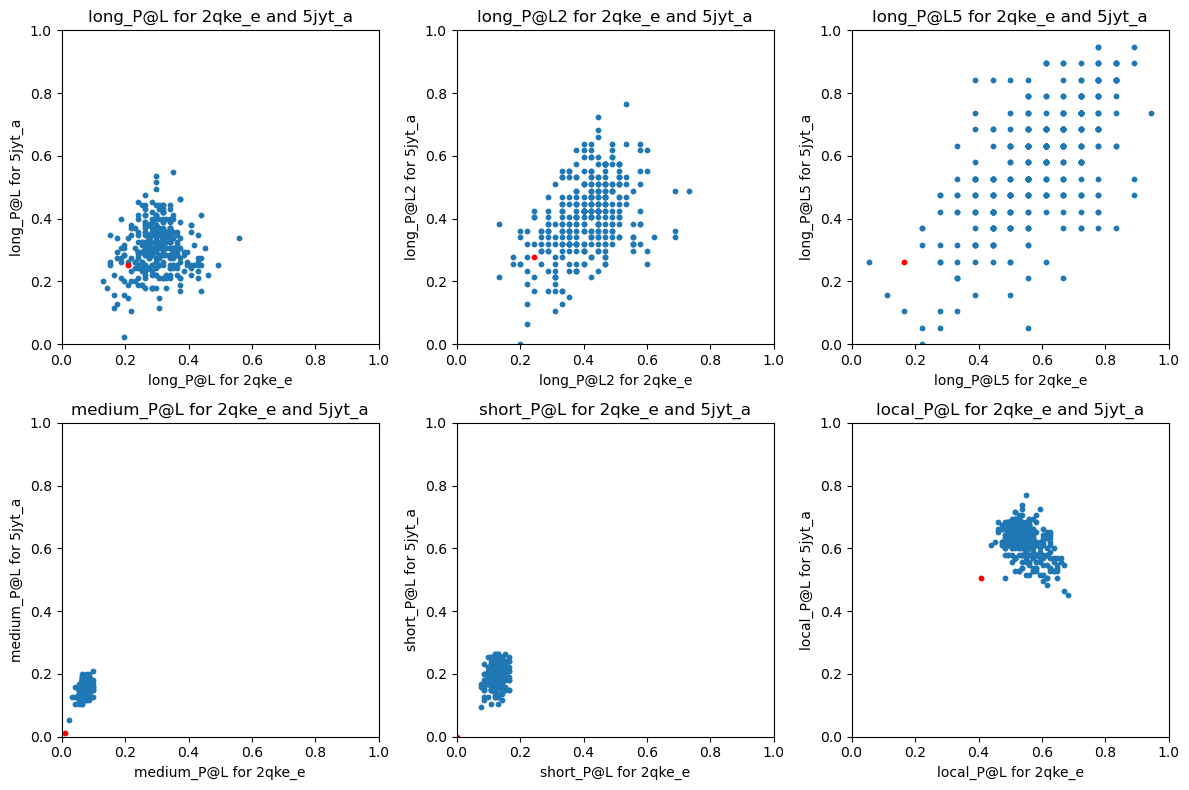

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Loop over the subplots and plot the data
for i, metric in enumerate(["long_P@L", "long_P@L2", "long_P@L5", "medium_P@L", "short_P@L", "local_P@L"]):
    row = i // 3
    col = i % 3
    axs[row, col].set_xlabel(f"{metric} for {REF_0}")
    axs[row, col].set_ylabel(f"{metric} for {REF_1}")
    axs[row, col].set_title(f"{metric} for {REF_0} and {REF_1}")
    
    axs[row, col].set_xlim([0, 1])
    axs[row, col].set_ylim([0, 1])
    axs[row, col].scatter(msa_transformer_results_0[metric][:-1], msa_transformer_results_1[metric][:-1], s=10)
    axs[row, col].scatter(msa_transformer_results_0[metric][-1:], msa_transformer_results_1[metric][-1:], s=10, c='r')

fig.tight_layout()
plt.show()